In [ ]:
!wget https://uofi.box.com/shared/static/q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip
!mkdir celeba_data
!unzip q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip -d celeba_data
!rm q4pf89jtkvjndi4f8ip7wofuulhhphjj.zip

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def show_images(images, color=False):
    if color:
        sqrtimg = int(np.ceil(np.sqrt(images.shape[2]*images.shape[3])))
    else:
        images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
        sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))


    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        if color:
            plt.imshow(np.swapaxes(np.swapaxes(img, 0, 1), 1, 2))
        else:
            plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    to_return = torch.randn((batch_size, dim))
    return to_return/torch.max(to_return)




In [18]:
import torch
from torch.optim.optimizer import Optimizer, required

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=2):
        """
        Reference:
        SPECTRAL NORMALIZATION FOR GENERATIVE ADVERSARIAL NETWORKS: https://arxiv.org/pdf/1802.05957.pdf
        """
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        self._make_params()

    def _update_u_v(self):
        """
        Implement Spectral Normalization
        Hint: 1: Use getattr to first extract u, v, w.
              2: Apply power iteration.
              3: Calculate w with the spectral norm.
              4: Use setattr to update w in the module.
        """
        w = getattr(self.module, self.name + "_bar")
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")

        reshapedw = w.view(w.size(0), -1)

        for i in range(self.power_iterations):
          mulwu = torch.mv(torch.t(reshapedw), u)
          mulwv = torch.mv(reshapedw, v)
          v = l2normalize(mulwu)
          u = l2normalize(mulwv)

        sigma = u.dot(reshapedw.mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))
        

    def _make_params(self):
        """
        No need to change. Initialize parameters.
        v: Initialize v with a random vector (sampled from isotropic distrition).
        u: Initialize u with a random vector (sampled from isotropic distrition).
        w: Weight of the current layer.
        """
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        """
        No need to change. Update weights using spectral normalization.
        """
        self._update_u_v()
        return self.module.forward(*args)



In [20]:
import torch

def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss.
    
    You should use the stable torch.nn.functional.binary_cross_entropy_with_logits 
    loss rather than using a separate softmax function followed by the binary cross
    entropy loss.
    
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
    
    onse =  torch.ones_like(logits_real)
    zeros = torch.zeros_like(logits_fake)

    loss_real = torch.nn.functional.binary_cross_entropy_with_logits (logits_real,onse)
    loss_fake = torch.nn.functional.binary_cross_entropy_with_logits (logits_fake,zeros )
    
    loss = loss_real + loss_fake
    
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss.
    
    You should use the stable torch.nn.functional.binary_cross_entropy_with_logits 
    loss rather than using a separate softmax function followed by the binary cross
    entropy loss.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    
    onse = torch.ones_like(logits_fake)
    loss = torch.nn.functional.binary_cross_entropy_with_logits(logits_fake, onse)
    
    return loss



def ls_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.
    
    Inputs:
    - scores_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    onse = torch.ones_like(scores_real)
    zeros = torch.zeros_like(scores_fake)

    loss = ((torch.nn.functional.mse_loss(scores_real, onse))/2 )+ ((torch.nn.functional.mse_loss(scores_fake, zeros))/2)
    
    return loss

def ls_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.
    
    Inputs:
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    onse = torch.ones_like(scores_fake)

    loss = (torch.nn.functional.mse_loss(scores_fake, onse))/2
    
    return loss

In [21]:
import torch
#from spectral_normalization import SpectralNorm
import torch.nn as nn

class Discriminator(torch.nn.Module):
  def __init__(self, input_channels=3):
    super(Discriminator, self).__init__()

    self.conv1 = SpectralNorm(nn.Conv2d(input_channels, 128, 4, 2, 1))
    self.conv2 = SpectralNorm(nn.Conv2d(128, 256, 4, 2, 1))
    self.conv3 = SpectralNorm(nn.Conv2d(256, 512, 4, 2, 1))
    self.conv4 = SpectralNorm(nn.Conv2d(512, 512, 4, 2, 1))
    self.conv5 = SpectralNorm(nn.Conv2d(512, 1, 4, 1, 0))
    self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)

  def forward(self, x):

    x = self.leaky_relu(self.conv1(x))
    x = self.leaky_relu(self.conv2(x))
    x = self.leaky_relu(self.conv3(x))
    x = self.leaky_relu(self.conv4(x))
    x = self.conv5(x)
    print(x.size())
    
    return x

class Generator(torch.nn.Module):
  def __init__(self, noise_dim, output_channels=3):
    super(Generator, self).__init__()    
    self.noise_dim = noise_dim
    self.linear = nn.Linear(self.noise_dim, 4*4*512)
    self.conv1 = nn.ConvTranspose2d(512, 256, 4, 2, 1)
    self.conv2 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
    self.conv3 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
    self.conv4 = nn.ConvTranspose2d(64, output_channels, 4, 2, 1)
    self.batch_norm1 = nn.BatchNorm2d(256)
    self.batch_norm2 = nn.BatchNorm2d(128)
    self.batch_norm3 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU(inplace=True)
    self.tanh = nn.Tanh()
  
  def forward(self, x):
    x = self.linear(x)
    x = x.view(-1, 512, 4, 4)
    x = self.relu(self.batch_norm1(self.conv1(x)))
    x = self.relu(self.batch_norm2(self.conv2(x)))
    x = self.relu(self.batch_norm3(self.conv3(x)))
    x = self.tanh(self.conv4(x))

    return x
    


In [22]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img

def train(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=128, noise_size=100, num_epochs=10, train_loader=None, device=None):
    """
    Train loop for GAN.
    
    The loop will consist of two steps: a discriminator step and a generator step.
    
    (1) In the discriminator step, you should zero gradients in the discriminator 
    and sample noise to generate a fake data batch using the generator. Calculate 
    the discriminator output for real and fake data, and use the output to compute
    discriminator loss. Call backward() on the loss output and take an optimizer
    step for the discriminator.
    
    (2) For the generator step, you should once again zero gradients in the generator
    and sample noise to generate a fake data batch. Get the discriminator output
    for the fake data batch and use this to compute the generator loss. Once again
    call backward() on the loss and take an optimizer step.
    
    You will need to reshape the fake image tensor outputted by the generator to 
    be dimensions (batch_size x input_channels x img_size x img_size).
    
    Use the sample_noise function to sample random noise, and the discriminator_loss
    and generator_loss functions for their respective loss computations.
    
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    - train_loader: image dataloader
    - device: PyTorch device
    """
    dgraph = []
    ggraph = []

    iter_count = 0
    for epoch in range(num_epochs):
        print('EPOCH: ', (epoch+1))
        for x, _ in train_loader:
            _, input_channels, img_size, _ = x.shape
            
            real_images = preprocess_img(x).to(device)  # normalize
            
            # Store discriminator loss output, generator loss output, and fake image output
            # in these variables for logging and visualization below
            d_error = None
            g_error = None
            fake_images = None

            D_solver.zero_grad()
            noise = sample_noise(batch_size, noise_size).to(device)
            d_error = discriminator_loss(D(real_images), D(G(noise)))
            dgraph.append(d_error.item())
            d_error.backward()
            D_solver.step()

            G_solver.zero_grad()
            noise = sample_noise(batch_size, noise_size).to(device)
            fake_images = G(noise)
            g_error = generator_loss(D(fake_images))
            ggraph.append(g_error.item())
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_error.item(),g_error.item()))
                disp_fake_images = deprocess_img(fake_images.data)  # denormalize
                imgs_numpy = (disp_fake_images).cpu().numpy()
                show_images(imgs_numpy[0:16], color=input_channels!=1)
                plt.show()
                print()
            iter_count += 1

    return dgraph,ggraph

# Generative Adversarial Networks

For this part of the assignment you implement two different types of generative adversarial networks. We will train the networks on the Celeb A dataset which is a large set of celebrity face images.

In [23]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "gpu")

# GAN loss functions

In this assignment you will implement two different types of GAN cost functions. You will first implement the loss from the [original GAN paper](https://arxiv.org/pdf/1406.2661.pdf). You will also implement the loss from [LS-GAN](https://arxiv.org/abs/1611.04076). 

### GAN loss

**TODO:** Implement the `discriminator_loss` and `generator_loss` functions in `gan/losses.py`.

The generator loss is given by:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: You should use the `torch.nn.functional.binary_cross_entropy_with_logits` function to compute the binary cross entropy loss since it is more numerically stable than using a softmax followed by BCE loss. The BCE loss is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$


Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [9]:
# from gan.losses import discriminator_loss, generator_loss

### Least Squares GAN loss

**TODO:** Implement the `ls_discriminator_loss` and `ls_generator_loss` functions in `gan/losses.py`.

We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

In [10]:
# from gan.losses import ls_discriminator_loss, ls_generator_loss

# GAN model architecture

**TODO:** Implement the `Discriminator` and `Generator` networks in `gan/models.py`.

We recommend the following architectures which are inspired by [DCGAN](https://arxiv.org/pdf/1511.06434.pdf):

**Discriminator:**

- convolutional layer with in_channels=3, out_channels=128, kernel=4, stride=2
- convolutional layer with in_channels=128, out_channels=256, kernel=4, stride=2
- batch norm
- convolutional layer with in_channels=256, out_channels=512, kernel=4, stride=2
- batch norm
- convolutional layer with in_channels=512, out_channels=1024, kernel=4, stride=2
- batch norm
- convolutional layer with in_channels=1024, out_channels=1, kernel=4, stride=1

Use padding = 1 (not 0) for all the convolutional layers.

Instead of Relu we LeakyReLu throughout the discriminator (we use a negative slope value of 0.2). You can use simply use relu as well.

The output of your discriminator should be a single value score corresponding to each input sample. See `torch.nn.LeakyReLU`.


**Generator:**

**Note:** In the generator, you will need to use transposed convolution (sometimes known as fractionally-strided convolution or deconvolution). This function is implemented in pytorch as `torch.nn.ConvTranspose2d`.

- transpose convolution with in_channels=NOISE_DIM, out_channels=1024, kernel=4, stride=1
- batch norm
- transpose convolution with in_channels=1024, out_channels=512, kernel=4, stride=2
- batch norm
- transpose convolution with in_channels=512, out_channels=256, kernel=4, stride=2
- batch norm
- transpose convolution with in_channels=256, out_channels=128, kernel=4, stride=2
- batch norm
- transpose convolution with in_channels=128, out_channels=3, kernel=4, stride=2

The output of the final layer of the generator network should have a `tanh` nonlinearity to output values between -1 and 1. The output should be a 3x64x64 tensor for each sample (equal dimensions to the images from the dataset).





In [11]:
# from gan.models import Discriminator, Generator

# Data loading: Celeb A Dataset

The CelebA images we provide have been filtered to obtain only images with clear faces and have been cropped and downsampled to 128x128 resolution.

In [25]:
batch_size = 128
scale_size = 64  # We resize the images to 64x64 for training

celeba_root = 'celeba_data'

In [26]:
celeba_train = ImageFolder(root=celeba_root, transform=transforms.Compose([
  transforms.Resize(scale_size),
  transforms.ToTensor(),
]))

celeba_loader_train = DataLoader(celeba_train, batch_size=batch_size, drop_last=True)

### Visualize dataset

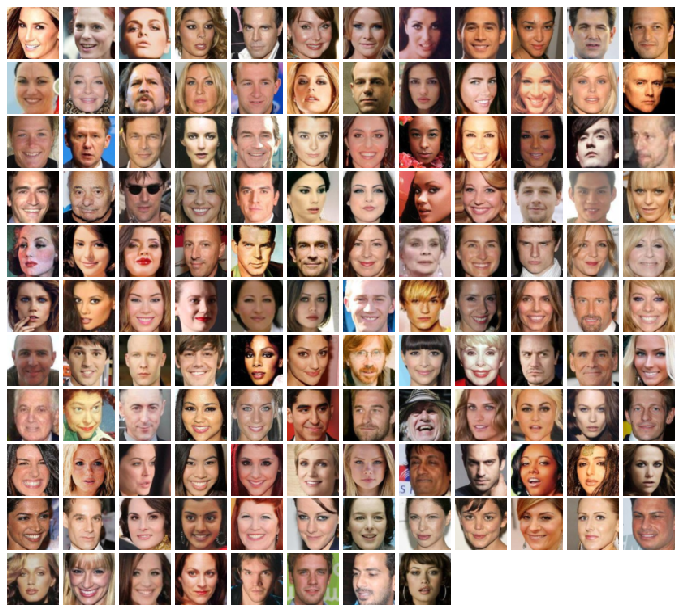

In [ ]:
imgs = next(iter(celeba_loader_train))[0].numpy()

show_images(imgs, color=True)

# Training 


**TODO:** Fill in the training loop in `gan/train.py`.

In [27]:
NOISE_DIM = 100
NUM_EPOCHS = 40
learning_rate = 0.0002

### Train GAN

In [28]:
D = Discriminator().to(device)
G = Generator(noise_dim=NOISE_DIM).to(device)

In [29]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas = (0.5, 0.999))

EPOCH:  1
Iter: 0, D: 1.377, G:1.084


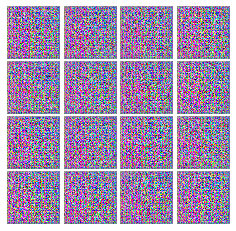


EPOCH:  2
Iter: 1000, D: 1.136, G:0.8982


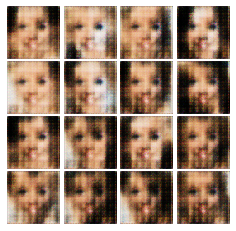


EPOCH:  3
Iter: 2000, D: 1.186, G:0.6611


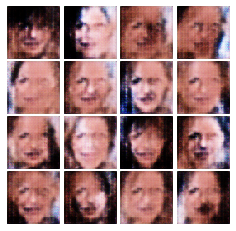


EPOCH:  4
Iter: 3000, D: 0.7734, G:1.977


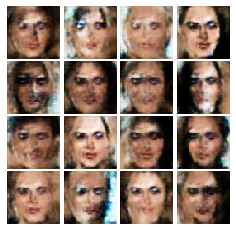


EPOCH:  5
Iter: 4000, D: 0.7634, G:1.856


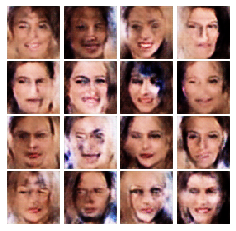


EPOCH:  6
Iter: 5000, D: 1.379, G:1.246


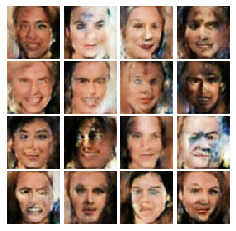


EPOCH:  7
Iter: 6000, D: 1.229, G:0.7574


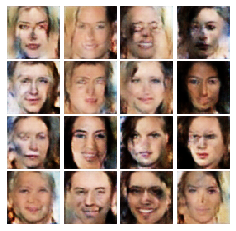


EPOCH:  8
Iter: 7000, D: 1.046, G:1.125


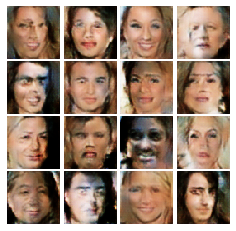


EPOCH:  9
Iter: 8000, D: 1.015, G:1.261


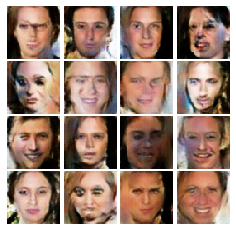


EPOCH:  10
Iter: 9000, D: 1.068, G:0.9685


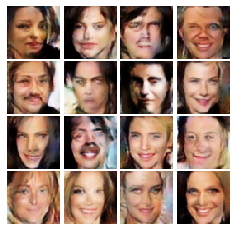


EPOCH:  11
Iter: 10000, D: 1.094, G:0.9006


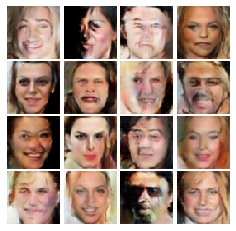


EPOCH:  12
Iter: 11000, D: 1.37, G:0.7497


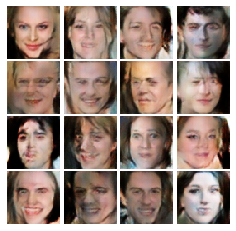


EPOCH:  13
Iter: 12000, D: 1.25, G:0.8398


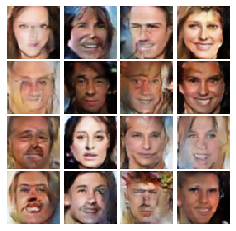


EPOCH:  14
Iter: 13000, D: 1.24, G:0.8762


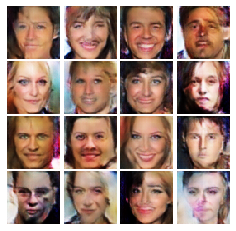


EPOCH:  15
Iter: 14000, D: 1.37, G:0.6898


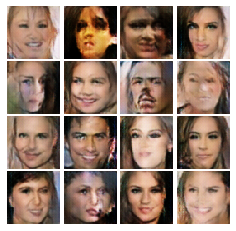


EPOCH:  16
Iter: 15000, D: 1.356, G:0.7457


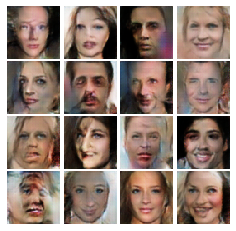


EPOCH:  17
Iter: 16000, D: 1.138, G:0.7697


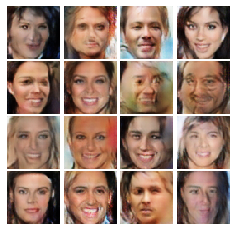


EPOCH:  18
Iter: 17000, D: 1.063, G:1.15


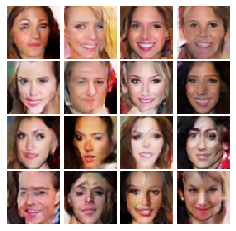


EPOCH:  19
Iter: 18000, D: 1.222, G:0.8825


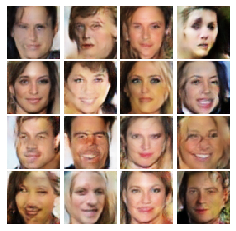


EPOCH:  20
Iter: 19000, D: 1.368, G:0.7098


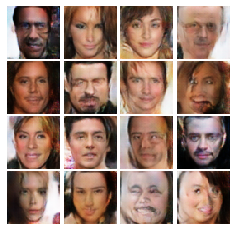


EPOCH:  21
Iter: 20000, D: 1.346, G:0.9097


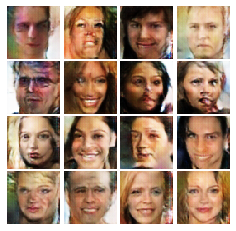

KeyboardInterrupt: 

In [ ]:
# original gan
dgraph,ggraph =  train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss,batch_size=128,noise_size=100, num_epochs=NUM_EPOCHS, show_every=1000,train_loader=celeba_loader_train, device=device)


In [ ]:
import matplotlib.pyplot as plt
  
plt.plot(dgraph, color='green', linestyle='dashed', linewidth = 1,marker='o', markerfacecolor='blue', markersize=1)

plt.plot(ggraph, color='red', linestyle='dashed', linewidth = 1,marker='o', markerfacecolor='blue', markersize=1)

plt.show()

### Train LS-GAN

In [ ]:
D = Discriminator().to(device)
G = Generator(noise_dim=NOISE_DIM).to(device)

In [ ]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas = (0.5, 0.999))

EPOCH:  1
Iter: 0, D: 0.5239, G:0.1502


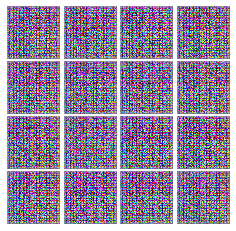


EPOCH:  2
Iter: 1000, D: 0.2043, G:0.2341


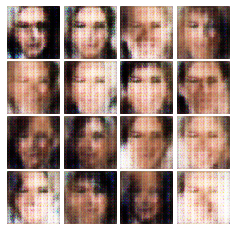


EPOCH:  3
Iter: 2000, D: 0.1659, G:0.4827


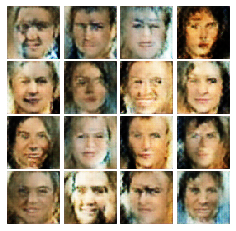


EPOCH:  4
Iter: 3000, D: 0.1175, G:0.3552


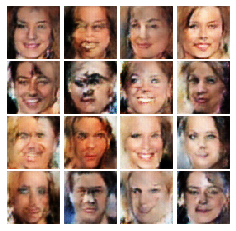


EPOCH:  5
Iter: 4000, D: 0.1884, G:0.1673


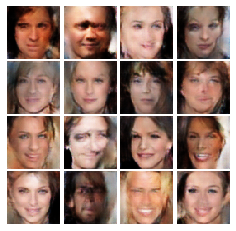


EPOCH:  6
Iter: 5000, D: 0.2195, G:0.1468


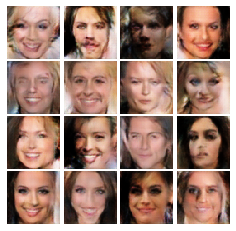


EPOCH:  7
Iter: 6000, D: 0.1726, G:0.2493


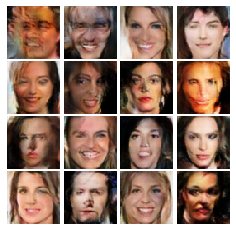


EPOCH:  8
Iter: 7000, D: 0.2317, G:0.1493


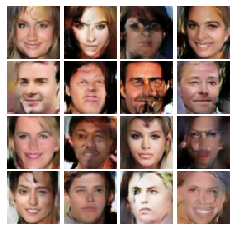


EPOCH:  9
Iter: 8000, D: 0.17, G:0.2631


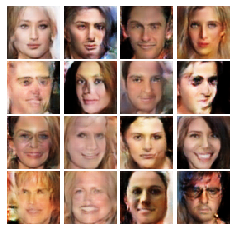


EPOCH:  10
Iter: 9000, D: 0.1462, G:0.2524


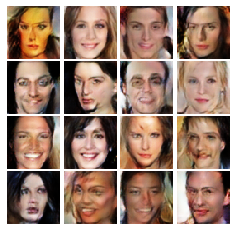


EPOCH:  11
Iter: 10000, D: 0.1968, G:0.4093


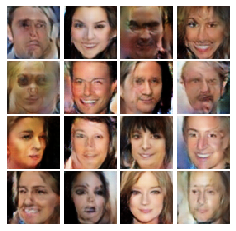


EPOCH:  12
Iter: 11000, D: 0.2363, G:0.1432


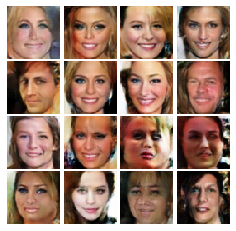


EPOCH:  13
Iter: 12000, D: 0.2347, G:0.1456


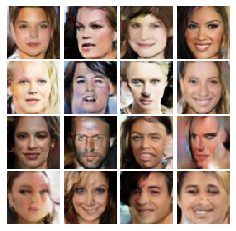


EPOCH:  14
Iter: 13000, D: 0.1935, G:0.1863


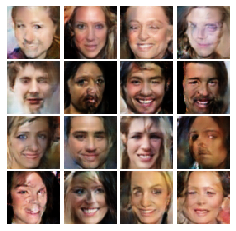


EPOCH:  15
Iter: 14000, D: 0.1803, G:0.2815


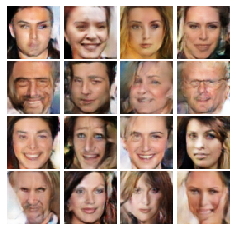


EPOCH:  16
Iter: 15000, D: 0.1848, G:0.229


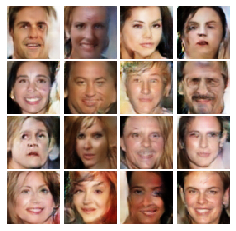


EPOCH:  17
Iter: 16000, D: 0.1496, G:0.2624


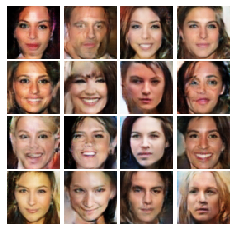


EPOCH:  18
Iter: 17000, D: 0.2153, G:0.1522


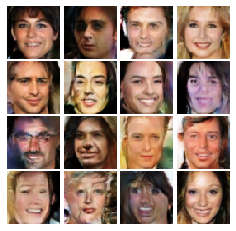


EPOCH:  19
Iter: 18000, D: 0.177, G:0.04737


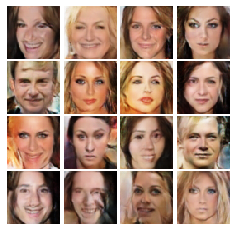


EPOCH:  20
Iter: 19000, D: 0.1377, G:0.3331


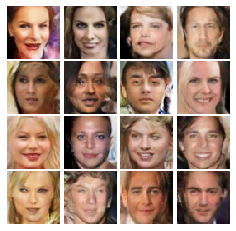


EPOCH:  21
Iter: 20000, D: 0.1453, G:0.2756


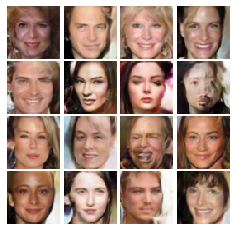


EPOCH:  22
Iter: 21000, D: 0.1782, G:0.2649


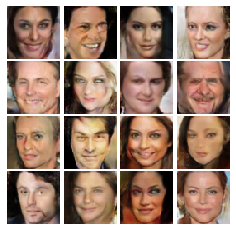


EPOCH:  23
Iter: 22000, D: 0.1785, G:0.5404


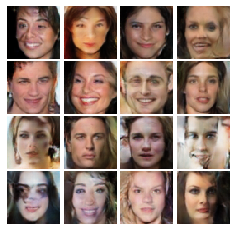


EPOCH:  24
Iter: 23000, D: 0.1652, G:0.4523


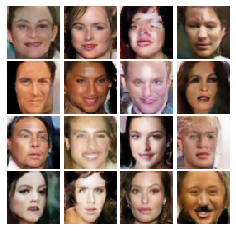


EPOCH:  25
Iter: 24000, D: 0.1196, G:0.1511


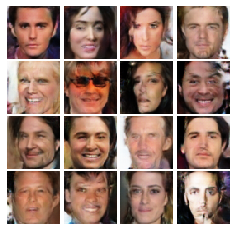


EPOCH:  26
Iter: 25000, D: 0.1476, G:0.3008


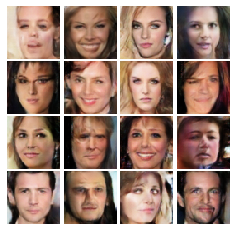


EPOCH:  27
Iter: 26000, D: 0.1988, G:0.1937


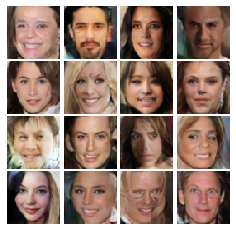


EPOCH:  28
Iter: 27000, D: 0.1735, G:0.2138


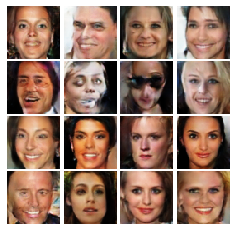


EPOCH:  29
Iter: 28000, D: 0.2007, G:0.201


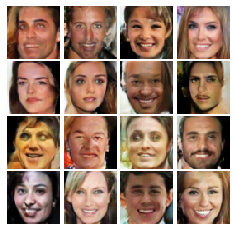


EPOCH:  30
Iter: 29000, D: 0.191, G:0.1785


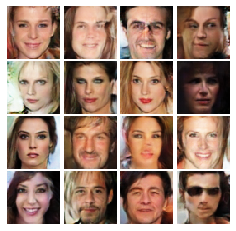

KeyboardInterrupt: 

In [ ]:
lsdgraph,lsggraph = train(D, G, D_optimizer, G_optimizer, ls_discriminator_loss, ls_generator_loss,batch_size=128, num_epochs=NUM_EPOCHS, show_every=1000,train_loader=celeba_loader_train, device=device)

In [ ]:
import matplotlib.pyplot as plt
  
plt.plot(lsdgraph, color='green', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='blue', markersize=1)

plt.plot(lsggraph, color='red', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='blue', markersize=1)

plt.show()

In [ ]:
noise = sample_noise(batch_size, 100).to(device)
fake_images = G(noise)
disp_fake_images = deprocess_img(fake_images.data)  # denormalize
imgs_numpy = (disp_fake_images).cpu().numpy()
show_images(imgs_numpy[0:16], color=3)
plt.show()
print()

            